# RSM 2307 Advanced Derivatives

Assignment 1

In [1]:
import matplotlib.pyplot as plt
from derivatives_pricing.securities.derivatives import *
import derivatives_pricing.sim.wiener as wiener
from portfolio_optimizer.port import *
from portfolio_optimizer.load_data import *
import pandas as pd
import math
import os
import pandas as pd
from pandas.tseries.offsets import *
hm = os.getcwd()
np.seterr(divide='ignore', invalid='ignore')
%matplotlib inline

# Part 1

## Question 1 - Part 1

### Load data from yahoo-finance:
The portfolio of stocks is equally weighted, and contains the following assets: </br>
'BMO.TO','BNS.TO','CM.TO','CWB.TO','NA.TO','RBNK.TO','TD.TO'

In [2]:
stocks = ['BMO.TO','BNS.TO','CM.TO','CWB.TO','NA.TO','RBNK.TO','TD.TO']


The data will be scraped from yahoo-finance and used to estimate the portfolio variance and standard deviation. A copy of the file will also be saved on the home root directory.

In [3]:
'''
Load data from yahoo-finance
OUTPUT - Print price statistics
'''
dic = {'init_port':{'BMO.TO':0,'BNS.TO':0,'CM.TO':0,
                 'CWB.TO':0,'NA.TO':0,'RY.TO':0,
                 'TD.TO':0},
                        'data_source':'yahoo',
                    "start_date":"2007-04-25",
                    "end_date": "2013-04-25"}

returns,data_,V_0,share_balance,tickers = data_reader(dic)
data_.to_csv(hm+'/Q1portdata.csv')

sanity-check, tickers in the right order: [ True  True  True  True  True  True  True]
0.0


### Calculate portfolio standard deviation:
The function cov() calculates the variance-covariance matrix Q. Given the portfolio weights, the standard deviation is $\sqrt{w^TQw}$, where w is the weight vector.

Given X the returns matrix, the variance covariance matrix can be otained by:

$var = \frac{1}{n}X^TX$

$std = \sqrt{var}$

In [4]:
'''
Calculating the volatility of the equally weighted portfolio:
w - equally weighted portfolio 1/(# of stocks)
q - covariance matrix of the portfolio
vol - volatility of the equally weighed portfoliowTQw
'''
start = returns.index[-1] - DateOffset(months=24)

w = np.ones(len(tickers))*1/len(tickers)
q = cov(returns.loc[start:]) #calculate the covariane using the matrix of returns
std = np.sqrt(w.T.dot(q).dot(w)) #daily std
vol = std*math.sqrt(252)

print('Portfolio annual volatility: {}'.format(vol))


Portfolio annual volatility: 0.13848729685550393


## Wiener process: Simulating the portfolio time series
The assumptions are:</br>
-  risk-free 1.5%
-  Initial value is 100
-  Time to maturiy 6
-  Number of time divisions = 12
-  Number of simulations = 1000
-  volatiliy 25.7%
-  dividend yield 3.86%

The wiener process, brownian motion, adjusted for pricing derivatives:
\\begin{equation}
lnS = lnS0 + (r_f-\sigma/2)\delta T + \sigma (\delta T)^{\frac{1}{2}}\epsilon
\\end{equation}

\\begin{equation}
S = S0e^{(r_f-\sigma/2)\delta T + \sigma (\delta T)^{\frac{1}{2}}\epsilon}
\\end{equation}

The dividend yield is factored on the stock price today as $S_0 = S_0e^{-qT}$

In [5]:
q = 0.0386
rf = 0.015
T = 6
S0 = 100
N = 12*200
n = 1000
stock_path,time,res = wiener.get_path(S0=S0*np.exp(-q*T),vol=vol,rf=rf,T=T,N=N,n=n)
index = [round(x,3) in np.arange(0.500,6.500,0.500) for x in time]

#### Simulated changes in the value of the portfolio:

The following plot shows the results for the monte carlo simulation. 

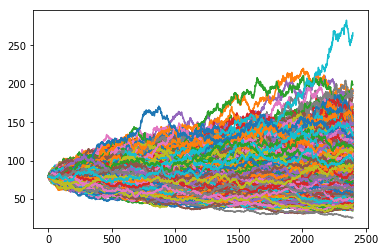

In [6]:
plt.plot(res);

As stated the payoff is based on the arithimetic average of the semi-annual returns. If the average is positive, the payof is the uncapped return over the principal invested (100).The variable value stores the semi-anual values of the stock obtained from the simulation. This is uswd nwxt to compute the expected average return and thus the expected pay-off:

The present value of the bond is $Be^{-rt}$ and the pay-off from the option needs to be discounted to PV in order to get us the final value of the PPN. The final results are:

## Value of the product

In [7]:
returns_port = np.mean(res[index]/stock_path[0]- 1)
pay_off = np.maximum(100*(returns_port),0)
#pay_off = 100*np.mean(res/stock_path[0]- 1)
p = pay_off*math.exp(-1*rf*T)
bond = S0*math.exp(-1*rf*T)
rf_eff = np.log(100/(p+bond))/T

print("Price of the option: {}".format(p))
print("Price of the bond: {}".format(bond))
print("Total cost: {}".format(p+bond))
print("Juros effetivos: {}".format(rf_eff))

Price of the option: 3.9598086732279962
Price of the bond: 91.39311852712282
Total cost: 95.35292720035082
Juros effetivos: 0.007930859146858397


# Question 2 - Part 1

### Replicating position:
1) Long on 3 calls at the money<br>
2) Short on 3 calls with strike price $k = (1+0.4/3)*SPX$<br>
3) Short on put with strike price $k = (0.9)*SPX$

In [8]:
'''
Calculate the price of the replicating portfolio
'''
max_SP500_change = 1+0.4/3
inf_bound = 0.9
q = 0.015
t = 2.083
r = 0.02
vol = 0.45
principal = 10
qty = principal/885.28
S0 = 885.28*math.exp(-q*t)
K = 885.28

options = {'c1':[S0,K,'call',3],
 'c2':[S0,K*(max_SP500_change ),'call',-3],
'p1':[S0,K*inf_bound,'put',-1]}

The BS function implements the Black S model to value an european option, the prices of the options are:

In [9]:
price={}
total=0
for i in options:
    price[i]= BS(options[i][0],options[i][1],r,
             vol,t,options[i][2])
    price[i] *= options[i][3]*qty
    total +=  price[i]    

call_BS: 221.81386615023524
call_BS: 183.06847823275206
put_BS: 162.78338002176775


Using the appropriate quantities $qty = \frac{pricipal}{index}$ , we get that the prices are:

In [10]:
pd.DataFrame.from_dict(price,orient='index')


,0
c1,7.516736
c2,-6.203748
p1,-1.838778


The total position, considering the Bond with face value of 10, will cost:

In [11]:
bond = principal*math.exp(-r*t)
print("Total option value: {}".format(total))
print("Bond price: {}".format(bond))
print("Total position value: {}".format(bond+total))

Total option value: -0.525790894059712
Bond price: 9.591958517268344
Total position value: 9.066167623208631


# Question 3 part 1

SPARQs structured investment issued by Morgan stanley. The product matures in july/20, 2009. The note was sold for 11.18. The buyer receives 0.2733 on october 20/2008, 0.2236 on each january 20/09, arpil 20/09 and july 20/09. In addition on july 20/09 the buyer receives 0.5 shares of Intel. MSFT has the right to call the note for 11.6337 on jan 20/09. Assume Intel shares closed at 20.77 on june/30, vol is 35.4% and interest rate is 3.13%. Intel pays dividends of 0.14 on august 5/08, nov 5/08, feb 4/09 and may 5/09.

Assumptions:
-  Intel closed at 20.77 on June 30
-  The volatility is 35.4%
-  The rate of interest is 3.13%
-  Intel pays dividends of $0.14 on August 5,
   2008, November 5, 2008, February 4, 2009, and May 5, 2009.

### Value of dividend payments:

In [12]:
S0 = 20.77*0.5 # value of 0.5 shares of intel
vol = 0.354
r = 0.0313
K = 11.6337

In [13]:
div_payments = np.array([0.14,0.14,0.14,0.14])
div_schedule = np.array([0.1861,0.3555,0.6083,0.8583])
dcf = np.exp(-div_schedule*r)
pv_div = np.sum(np.multiply(div_payments,dcf))
div_remaining_v = np.sum(np.multiply(div_payments,dcf)[:2]) #used in the stike of the option
print("PV of the remaining dividend payments: {}".format(div_remaining_v))

PV of the remaining dividend payments: 0.2776377141676017


### Value of coupon payments:

In [14]:
coupon_schedule = np.array([0.311,0.566,0.816,1.069])
coupon_payments = np.array([0.2733,0.2236,0.2236,0.2236])
dcf = np.exp(-coupon_schedule*r)
pv_bond = np.sum(np.multiply(coupon_payments,dcf))
print("PV of the bond payments: {}".format(pv_bond))
bond_remaining_v = np.sum(np.multiply(coupon_payments,dcf)[2:]) #used in the stike of the option

PV of the bond payments: 0.9245297350629091


### Value of the call option:
This pay-off can be replicated by an european option. MS is on a long position on this call that gives the right to claim 0.5 shares of Intel for 11.6337. Next, we are using the BS model to calculate the value of this european option. 

If the call is exercised the holder of the note will loose the rights to receive coupon payments, thus the pv of the coupon payments will be facotred increasing the price of the underlaying today $S_0 = S_0 + PV(coupons)$.

Moreover, we need to factor the dividend payments that microsoft will forego by holding the option, not the asset.

In [15]:
S0 = 20.77 # value of 0.5 shares of intel
vol = 0.354
r = 0.0313
K = 11.6337*2

t = 0.566
qty = 0.5
call = BS(S0+bond_remaining_v+0.3938,K,r,vol,t,'call')
pv_call = qty*call

print("PV of the call option: {}".format(pv_call))

call_BS: 1.7772565843711288
PV of the call option: 0.8886282921855644


### Value of the note:
The note value comes from the coupon payments and the 0.5 shares of intel that shall be payd at maturity. The option that MSFT holds to buy back the note reduces the value of the product.

In [16]:
total = S0/2 + pv_bond - pv_call
summary = pd.DataFrame.from_dict({"Stock (+)":S0/2,"Bond (+)":pv_bond,"call (-)":pv_call,"Total":total},orient='index')
summary.columns = ["Value"]
print(summary)

               Value
Stock (+)  10.385000
Bond (+)    0.924530
call (-)    0.888628
Total      10.420901
